# Balance Eye Project
**MALIS Course, EURECOM FALL 2019** <br>
**Supervised by:** Maria A. Zuluaga <br>
**Students :** ALIOUI Dhiaeddine, BOUAOUN Radhwen, HMAIED Oumaima

**Description :**  <br>
The problem of fruit/vegetable recognition is a recurrent problem that a consumer can face when he wants to buy fresh products. We personally faced such problem several times while in Carrefour and we also noticed that a lot of people, and more precisely elderly, spend a lot of time in front of the balance trying to identify fruits/vegetables types. The Balance Eye project aims to make the balance smarter by giving it the ability to classify the fruits and vegetables.


In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
from sklearn.metrics import confusion_matrix, classification_report

from keras.optimizers import Adadelta
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

#Hyperparameters setting
learning_rate = 0.1 
min_learning_rate = 0.00001 
learning_rate_reduction_factor = 0.5  
patience = 3  
verbose = 1  

image_size = (100, 100)  
input_shape = (100, 100, 3)  


base_dir = '.'  

#Test Data Path
test_dir = os.path.join(base_dir, 'Test')

#Train Data Path
train_dir = os.path.join(base_dir, 'Training')

#Saved model path
output_dir = 'output_files'  


labels = os.listdir(train_dir)
num_classes = len(labels)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    


Using TensorFlow backend.


**Create the Train, Validaiton and Test Data**

In this step we prepare the data for the next steps ( training & test ). The preparation is to take the images, do some data augmentation, and of course resize them to the target size ( 100 x 100 x 3 )

In [2]:
from keras.preprocessing.image import ImageDataGenerator

validation_percent = 10/100 # 10% of the training data is used for validation
batch_size = 50

train_datagen = ImageDataGenerator(width_shift_range=0.0,
                                   height_shift_range=0.0,
                                   zoom_range=0.0,
                                   horizontal_flip=True,
                                   vertical_flip=True,  # randomly flip images for data augmentation
                                   validation_split=validation_percent)  # percentage indicating how much of the training set should be kept for validation
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, class_mode='sparse',
                                                  batch_size=batch_size, shuffle=True, subset='training', classes=labels)

validation_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, class_mode='sparse',
                                                       batch_size=batch_size, shuffle=False, subset='validation', classes=labels)

test_gen = test_datagen.flow_from_directory(test_dir, target_size=image_size, class_mode='sparse',
                                                batch_size=batch_size, shuffle=False, subset=None, classes=labels)

Found 55393 images belonging to 120 classes.
Found 6125 images belonging to 120 classes.
Found 20624 images belonging to 120 classes.


**Notice :** as we can see, the data contains 120 type of fruits and vegetables.  

**Define the network Architecture :** 
We tried many architecture of CNN with different numbers of layers and different numbers of neurons per layer. The following architecture seems to be the best one used for fruit classification. We implemented the CNN using keras, as it is the simplest way to do that.

In [3]:
# Create a custom layer that converts the original image from 
# RGB to HSV and grayscale and concatenates the results
# forming in input of size 100 x 100 x 4 
def image_process(x):
    import tensorflow as tf
    hsv = tf.image.rgb_to_hsv(x)
    gray = tf.image.rgb_to_grayscale(x)
    rez = tf.concat([hsv, gray], axis=-1)
    return rez


def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    img_input_process = Lambda(image_process)(img_input)

    conv1 = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(img_input_process)
    activ1 = Activation('relu', name='conv1_relu')(conv1)
    
    maxPool1 = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(activ1)
    
    conv2 = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(maxPool1)
    activ2 = Activation('relu', name='conv2_relu')(conv2)
    
    maxPool2 = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(activ2)
    
    conv3 = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(maxPool2)
    activ3 = Activation('relu', name='conv3_relu')(conv3)
    
    maxPool3 = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(activ3)
    
    conv4 = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(maxPool3)
    activ4 = Activation('relu', name='conv4_relu')(conv4)
    
    maxPool4 = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(activ4)
    
    flatten = Flatten()(maxPool4)
    
    fully_connected1 = Dense(1024, activation='relu', name='fcl1')(flatten)
    
    fully_connected1 = Dropout(0.2)(fully_connected1)
    
    fully_connected2 = Dense(128, activation='relu', name='fcl2')(fully_connected1)
    
    fully_connected2 = Dropout(0.2)(fully_connected2)
    
    Output_layer = Dense(num_classes, activation='softmax', name='predictions')(fully_connected2)
    
    result = Model(inputs=img_input, outputs=Output_layer)
    return result

**The function of Training and evaluation of the model** : 

In [4]:
def train_and_evaluate_model(model, name="", epochs=5, batch_size=50, verbose=verbose, useCkpt=False):
    print(model.summary())
    
    #create the file to save the model
    model_out_dir = os.path.join(output_dir, name)
    if not os.path.exists(model_out_dir):
        os.makedirs(model_out_dir)
    if useCkpt:
        model.load_weights(model_out_dir + "/model.h5")

    #Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates,
    # instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done.
    optimizer = Adadelta(lr=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    #Keras provides the ReduceLROnPlateau that will adjust the learning rate when a plateau in model 
    # performance is detected, e.g. no change for a given number of training epochs. This callback is designed 
    # to reduce the learning rate after the model stops improving with the hope of fine-tuning model weights.
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                                factor=learning_rate_reduction_factor, min_lr=min_learning_rate)
    
    #Save callback
    save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_acc', verbose=verbose, 
                                 save_best_only=True, save_weights_only=False, mode='max', period=1)
    
    history = model.fit_generator(generator=train_gen,
                                  epochs=epochs,
                                  steps_per_epoch=(train_gen.n // batch_size) + 1,
                                  validation_data=validation_gen,
                                  validation_steps=(validation_gen.n // batch_size) + 1,
                                  verbose=verbose,
                                  callbacks=[learning_rate_reduction, save_model])
    
    #Load the saved model
    model.load_weights(model_out_dir + "/model.h5")

    #Validation and test phase
    validation_gen.reset()
    
    loss_v, accuracy_v = model.evaluate_generator(validation_gen, steps=(validation_gen.n // batch_size) + 1, verbose=verbose)
    loss, accuracy = model.evaluate_generator(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=verbose)
    print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
    print("Test: accuracy = %f  ;  loss_v = %f" % (accuracy, loss))



**Train and evalute the model :** Now let's train and test our model. As we discovered that the accuracy reach good value in the fifth epoch, we decided to train the model during 5 epoch only. 

In [5]:
#Create the model
model = network(input_shape=input_shape, num_classes=num_classes)
#train and evalute it 
train_and_evaluate_model(model, epochs=5, name="Fruit Model")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 100, 4)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1616      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0         
__________

In [6]:
#Test the model on real case
model = network(input_shape=input_shape, num_classes=num_classes)
model.load_weights("./output_files/Fruit Model/model.h5")

['apple.jpg', 'oranges.png', 'pimentv.jpg', 'Strawberry.jpg', 'orange.jpg', 'piment.jpg', 'melon.jpeg', 'kiwi.jpg', 'poivron.jpg', 'banana.jpeg', 'avocado.jpg', 'tomato.jpg', '.ipynb_checkpoints']
============== Test on real images from internet =================


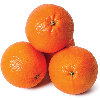

1/1 [==============================] - 0s 125ms/step
[90, 106, 65, 30, 48]
[0.9995005130767822, 0.00024113620747812092, 0.00019740741117857397, 1.837706076912582e-05, 1.4536439266521484e-05]
['Pear Red', 'Kaki', 'Cherry Rainier', 'Pitahaya Red', 'Redcurrant']



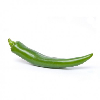

1/1 [==============================] - 0s 10ms/step
[12, 68, 91, 33, 101]
[0.9999983310699463, 1.6351064004993532e-06, 8.988698674272655e-09, 1.0874018352424741e-09, 4.636922235068397e-10]
['Banana Lady Finger', 'Banana', 'Cactus fruit', 'Pear Williams', 'Banana Red']



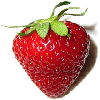

1/1 [==============================] - 0s 11ms/step
[12, 35, 48, 36, 106]
[0.9975584745407104, 0.002433589193969965, 4.505836386670126e-06, 1.861932560132118e-06, 1.4580493825633312e-06]
['Pitahaya Red', 'Strawberry', 'Pear Red', 'Tomato 2', 'Banana Red']



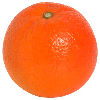

1/1 [==============================] - 0s 9ms/step
[105, 90, 30, 83, 23]
[0.9999865293502808, 6.72987653160817e-06, 3.971035766880959e-06, 2.5228493996110046e-06, 1.9564102160529728e-07]
['Clementine', 'Grapefruit Pink', 'Kaki', 'Redcurrant', 'Tomato Cherry Red']



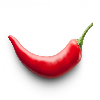

1/1 [==============================] - 0s 10ms/step
[81, 48, 66, 101, 12]
[0.9996684789657593, 0.00018681891378946602, 6.0843274695798755e-05, 5.0801078032236546e-05, 2.7260874048806727e-05]
['Banana Red', 'Banana Lady Finger', 'Tomato 3', 'Pear Red', 'Salak']



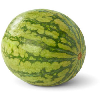

1/1 [==============================] - 0s 10ms/step
[108, 99, 107, 100, 76]
[0.7152883410453796, 0.28407034277915955, 0.0006364772561937571, 4.743263616546756e-06, 6.669893082289491e-08]
['Melon Piel de Sapo', 'Cauliflower', 'Ginger Root', 'Mulberry', 'Onion Red Peeled']



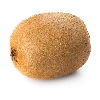

1/1 [==============================] - 0s 11ms/step
[88, 65, 56, 72, 86]
[0.9832369685173035, 0.016386227682232857, 0.00030132787651382387, 4.537593849818222e-05, 8.020640962058678e-06]
['Physalis with Husk', 'Carambula', 'Hazelnut', 'Cherry Rainier', 'Cantaloupe 2']



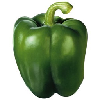

1/1 [==============================] - 0s 10ms/step
[13, 116, 71, 69, 16]
[0.39484497904777527, 0.24918727576732635, 0.1432754397392273, 0.10455039143562317, 0.03838528320193291]
['Potato White', 'Rambutan', 'Potato Red', 'Potato Sweet', 'Beetroot']



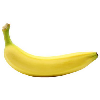

1/1 [==============================] - 0s 10ms/step
[118, 33, 58, 59, 101]
[0.951568603515625, 0.039985544979572296, 0.007883823476731777, 0.00025383822503499687, 0.00025247607845813036]
['Banana Lady Finger', 'Pepino', 'Pear Monster', 'Banana', 'Grape White 2']



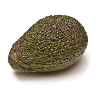

1/1 [==============================] - 0s 11ms/step
[108, 106, 100, 99, 3]
[0.8111146688461304, 0.07899881154298782, 0.044328730553388596, 0.027166204527020454, 0.021905316039919853]
['Strawberry Wedge', 'Mulberry', 'Cauliflower', 'Pitahaya Red', 'Onion Red Peeled']



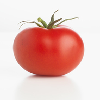

1/1 [==============================] - 0s 8ms/step
[30, 50, 5, 48, 12]
[0.9646987915039062, 0.035290949046611786, 9.361266165797133e-06, 4.563989648431743e-07, 2.0308863213358563e-07]
['Banana Red', 'Pear Red', 'Granadilla', 'Nut Pecan', 'Kaki']



In [7]:
from PIL import Image
import numpy

real_images_folder = os.path.join(base_dir, 'Real Test Data')
real_images = os.listdir(real_images_folder)
print(real_images)
print("============== Test on real images from internet =================")
for img in real_images[1:-1]:
    im = Image.open("Real Test Data/"+img)
    resized_im = im.resize((100, 100))
    display(resized_im)
    test_pic = numpy.array(resized_im)
    
    test_pic = np.reshape(test_pic,[1,100,100,3])
    prediction=model.predict(x=test_pic,batch_size = None, verbose = 1, steps = 1 )

    prediction_list=prediction[0].tolist()
    normalized = [float(i)/max(prediction_list) for i in prediction_list]


    ind_max = sorted(range(len(normalized)), key = lambda sub: normalized[sub])[-5:] 
    

    print(ind_max)
    Prediction_labels= [labels[i] for i in ind_max]
    Proba=[prediction_list[i] for i in ind_max]
    print(Proba[::-1])
    print(Prediction_labels[::-1])
    print("==========================================\n")
    


**Result :** <br> 
The obtained result using the test data taken from the dataset are very good ( acc = 0.97 ), but when we tried to classify some images of fruits taken from the internet we didn't get a good one. This is due to the nature of the dataset which contains images with white background, which is not the case when the algorithm will be applied in a real scenario, also, in every class's data ( fruit or vegetable ) we have the same fruit or vegetable pictured from different angle. A good training for the model needs a more realistic dataset ( Different backgrounds, different number of fruits/vegetables per image, ... )
To  make our model more realistic we should collect real fruits and vegetables from a supermarket.